In [90]:
from datetime import datetime 
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

!pip install torchsummaryX --quiet
from torchsummaryX import summary as summaryX
from torchsummary import summary

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Loading MNIST

CUDA (Compute Unified Device Architecture) is a programming model and parallel computing platform developed by Nvidia. Using CUDA, one can maximize the utilization of Nvidia-provided GPUs, thereby improving the computation power and performing operations away faster by parallelizing the tasks. PyTorch provides a torch.cuda library to set up and run the CUDA operations. Before using the CUDA, we have to make sure whether CUDA is supported by our System.


In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [65]:
learning_rate = 0.01
num_epochs = 10

# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transforms, download=True)
valid_dataset = datasets.MNIST(root='mnist_data', train=False, transform=transforms, download=True)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)

# Plotting the images

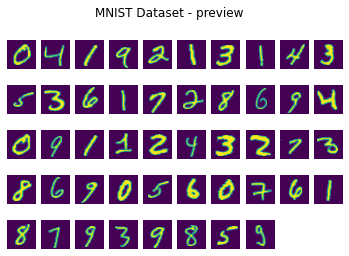

In [76]:
N_COLS = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, N_COLS*N_ROWS - 1):
  plt.subplot(N_ROWS, N_COLS, index)
  plt.axis('off')
  plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Dataset - preview');

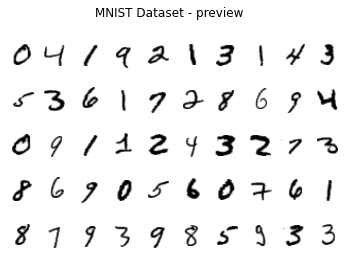

In [78]:
fig = plt.figure()
for index in range(1, N_COLS * N_ROWS + 1):
    plt.subplot(N_ROWS, N_COLS, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

* model.train() ---> tells your model that you are training the model. This helps inform layers such as Dropout and BatchNorm, which are designed to behave differently during training and evaluation. For instance, in training mode, BatchNorm updates a moving average on each new batch; whereas, for evaluation mode, these updates are frozen.

* optimizer.zero_grad() ---> optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.

* loss.backward() ---> computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x.
      x.grad += dloss/dx

* optimizer.step updates the value of x using the gradient x.grad.
      x += -lr * x.grad

* torch.no_grad() ---> Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). It will reduce memory consumption for computations that would otherwise have requires_grad=True. In this mode, the result of every computation will have requires_grad=False, even when the inputs have requires_grad=True.

In [88]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''

    correct_pred = 0
    n = 0


    with torch.no_grad():
        model.eval()
        for X,y_true in data_loader:

          X = X.to(device)
          y_true = y_true.to(device)

          _, y_prob = model(X)
          _, predicted_labels = torch.max(y_prob,1)

          n += y_true.size(0)
          correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''

    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))
    ax.plot(train_losses, color='blue', label= 'Training loss')
    ax.plot(valid_losses, color='red', label= 'Validation loss')
    ax.set(title='Loss over epochs',
           xlabel='Epoch',
           ylabel='Loss')
    plt.legend()
    plt.show()

    # change the plot style to default
    plt.style.use('default')

def train(train_loader, model,criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''
    
    model.train()    
    running_loss = 0

    for X, y_true in train_loader:

        optimizer.zero_grad()           # Sets the gradients of all optimized torch.Tensor s to zero.

        X = X.to(device)
        y_true = y_true.to(device)

        # forward paas
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item()*X.size(0)        # X.size() ----> Returns the size of the self tensor

        # Backward pass
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
      
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader,epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''

    # set objects for storing metrics
    best_loss = 10e10
    train_losses = []
    valid_losses = []


    # Train model
    for epoch in range(0,epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model,criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every -1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [82]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6,
                           kernel_size=5, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16,
                           kernel_size=5, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=120,
                           kernel_size=5, stride=1, padding=0)
    self.linear1 = nn.Linear(in_features=120, out_features=84)
    self.linear2 = nn.Linear(in_features=84, out_features=10)
    self.tanh = nn.Tanh()
    self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)


  def forward(self,x):
    x = self.conv1(x)
    x = self.tanh(x)
    x = self.avgpool(x)
    x = self.conv2(x)
    x = self.tanh(x)
    x = self.avgpool(x)
    x = self.conv3(x)
    x = self.tanh(x)

    x = torch.flatten(x, 1)
    x = self.linear1(x)
    x = self.tanh(x)
    logits = self.linear2(x)
    probs = F.softmax(logits, dim=1)

    return logits, probs


In [85]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [84]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

x = torch.randn(64,1,32,32)
output,_ = model(x)
print(output.shape)
summary(model, (1,32,32))

torch.Size([64, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
              Tanh-8            [-1, 120, 1, 1]               0
            Linear-9                   [-1, 84]          10,164
             Tanh-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size 

14:36:47 --- Epoch: 0	Train loss: 0.1181	Valid loss: 0.1159	Train accuracy: 96.69	Valid accuracy: 96.47
14:37:38 --- Epoch: 1	Train loss: 0.1097	Valid loss: 0.1075	Train accuracy: 96.86	Valid accuracy: 96.78
14:38:51 --- Epoch: 2	Train loss: 0.1059	Valid loss: 0.1156	Train accuracy: 96.88	Valid accuracy: 96.64
14:39:47 --- Epoch: 3	Train loss: 0.1253	Valid loss: 0.1162	Train accuracy: 96.41	Valid accuracy: 96.56
14:40:41 --- Epoch: 4	Train loss: 0.1183	Valid loss: 0.1263	Train accuracy: 96.21	Valid accuracy: 96.49
14:41:33 --- Epoch: 5	Train loss: 0.1281	Valid loss: 0.1272	Train accuracy: 96.56	Valid accuracy: 96.52
14:42:34 --- Epoch: 6	Train loss: 0.1162	Valid loss: 0.1160	Train accuracy: 96.93	Valid accuracy: 96.73
14:43:27 --- Epoch: 7	Train loss: 0.1184	Valid loss: 0.1166	Train accuracy: 96.54	Valid accuracy: 96.56
14:44:22 --- Epoch: 8	Train loss: 0.1187	Valid loss: 0.1145	Train accuracy: 96.72	Valid accuracy: 96.64
14:45:22 --- Epoch: 9	Train loss: 0.1156	Valid loss: 0.1148	Trai

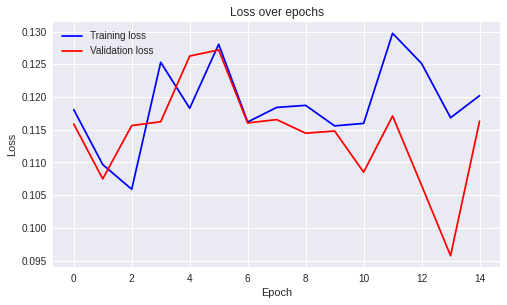

In [97]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, device)

# Evaluating the predictions

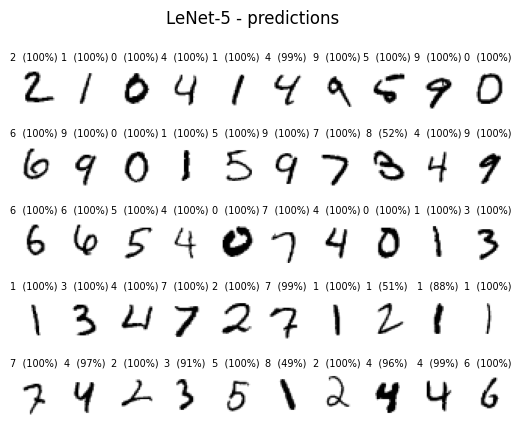

In [98]:
N_COLS = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1,  N_COLS* N_ROWS + 1):
    plt.subplot(N_ROWS, N_COLS, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')

    with torch.no_grad():
        model.eval()
        _,probs = model(valid_dataset[index][0].unsqueeze(0))

    title = f'{torch.argmax(probs)}  ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');

In [ ]:
# remove the downloaded dataset
!rm -r mnist_data

In [ ]:
# subplots vs subplot
# logit for loss or porb?
# plot fix
# add description from file downloaded